# Notebook 07: Phase 4 - Dự báo đệ quy (Recursive Forecasting)

**Mục tiêu:**
- Thực hiện **Dự báo đệ quy (Recursive Forecasting)** để mô phỏng bài toán thực tế: Dự báo nhiều bước (Multi-step ahead) từ 2015 đến 2019.
- **Thách thức**: Không giống như kiểm thử đơn giản (Teacher Forcing - dùng Lag thực tế), ở đây chúng ta phải dùng **kết quả dự báo của năm t** làm đầu vào (Lag) cho dự báo năm t+1.
- **Đánh giá**: So sánh sai số tích lũy (Error Propagation) giữa các chiến lược:
    1. **Baseline**: Linear Regression Toàn cầu (Global).
    2. **Chiến lược đề xuất**: Linear Regression theo Cụm (Cluster-based).

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sys
import os
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Thêm src vào đường dẫn
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

SPLIT_YEAR = 2015
TEST_END_YEAR = 2019
TARGET = 'Value_co2_emissions_kt_by_country'
LAG_TARGET = f'{TARGET}_lag1'

# Tải tham số tối ưu (Best Params)
try:
    with open('../data/results/best_hyperparameters.json', 'r') as f:
        best_params = json.load(f)
    print("Đã tải tham số tối ưu thành công.")
except FileNotFoundError:
    print("Cảnh báo: Không tìm thấy file tham số. Sử dụng tham số mặc định.")
    best_params = {"Linear Regression": {"alpha": 10.0}}

Đã tải tham số tối ưu thành công.


## 1. Chuẩn bị Dữ liệu & Tái lập Cụm (Clustering)
Chúng ta cần tải dữ liệu và thực hiện lại bước phân cụm (Clustering) giống Phase 3, đảm bảo chỉ dùng dữ liệu TRAIN để tránh rò rỉ thông tin.

In [2]:
# 1.1 Tải dữ liệu
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')

# Đồng bộ index giữa 2 file
common_idx = df_common.index.intersection(df_lr.index)
df_lr = df_lr.loc[common_idx]
df_lr['Year'] = df_common.loc[common_idx, 'Year']
df_lr['Entity'] = df_common.loc[common_idx, 'Entity']

# Xác định các cột Lag cần cập nhật đệ quy
# Lưu ý: Trong bài này ta tập trung cập nhật Lag Target. 
# Các Lag khác (GDP, Energy) giả định là biến ngoại sinh đã biết (Exogenous variables).
lag_cols = [c for c in df_lr.columns if 'lag' in c]
target_lag_col = next((c for c in lag_cols if TARGET in c), None)

print(f"Cột Lag mục tiêu cần cập nhật: {target_lag_col}")

# 1.2 Thực hiện Phân cụm (K-Means) trên tập Train (< 2015)
cluster_cols = [
    'gdp_per_capita', 
    'Access to electricity (% of population)', 
    'Renewable energy share in the total final energy consumption (%)', 
    'Primary energy consumption per capita (kWh/person)'
]

# Tính trung bình hồ sơ quốc gia (Chỉ dùng dữ liệu quá khứ)
df_profile = df_common[df_common['Year'] < SPLIT_YEAR].groupby('Entity')[cluster_cols].mean().dropna()

# Chuẩn hóa và Phân cụm
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Gán nhãn Cluster vào dữ liệu chính
df_lr['Cluster'] = df_lr['Entity'].map(df_profile['Cluster'])

# Loại bỏ các dòng không có Cluster (do thiếu dữ liệu hồ sơ)
df_lr.dropna(subset=['Cluster'], inplace=True)
df_lr['Cluster'] = df_lr['Cluster'].astype(int)

print(f"Kích thước dữ liệu sau khi gán Cluster: {df_lr.shape}")

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 24)
Loaded data from ../data/processed/lr_final_prep.csv: (3260, 196)
Cột Lag mục tiêu cần cập nhật: Value_co2_emissions_kt_by_country_lag1
Kích thước dữ liệu sau khi gán Cluster: (3260, 198)


## 2. Huấn luyện Mô hình (Training)
Chúng ta sẽ huấn luyện 2 hệ thống song song:
1. **Baseline Global**: Một mô hình Ridge duy nhất cho tất cả.
2. **Cluster-based**: 3 mô hình Ridge riêng biệt cho 3 Cụm.

In [3]:
models_cluster = {}
model_global = None
params_lr = best_params.get('Linear Regression', {"alpha": 10.0})

# Tách dữ liệu Train (Trước 2015)
train_full = df_lr[df_lr['Year'] < SPLIT_YEAR]

drop_cols_train = [TARGET, 'Year', 'Cluster', 'Entity']
feature_cols = [c for c in df_lr.columns if c not in drop_cols_train]

print("Đang huấn luyện mô hình...")

# 2.1 Huấn luyện Global Model
X_train_global = train_full[feature_cols]
y_train_global = train_full[TARGET]
model_global = Ridge(**params_lr)
model_global.fit(X_train_global, y_train_global)
print("- Global Model: Hoàn tất.")

# 2.2 Huấn luyện Cluster Models
for c in sorted(df_lr['Cluster'].unique()):
    data_c = train_full[train_full['Cluster'] == c]
    if len(data_c) > 0:
        X_train_c = data_c[feature_cols]
        y_train_c = data_c[TARGET]
        
        model_c = Ridge(**params_lr)
        model_c.fit(X_train_c, y_train_c)
        models_cluster[c] = model_c
        print(f"- Cluster {c} Model: Hoàn tất ({len(data_c)} mẫu).")

Đang huấn luyện mô hình...
- Global Model: Hoàn tất.
- Cluster 0 Model: Hoàn tất (1218 mẫu).
- Cluster 1 Model: Hoàn tất (406 mẫu).
- Cluster 2 Model: Hoàn tất (652 mẫu).


## 3. Vòng lặp Dự báo Đệ quy (Recursive Forecasting Loop)
Đây là phần cốt lõi của Notebook. Chúng ta sẽ dự báo từng năm một (2015 -> 2019).

**Quy trình cho năm T:**
1. Lấy dữ liệu đầu vào của năm T (bao gồm Lag của năm T-1).
2. Dự báo Target năm T.
3. **Cập nhật dữ liệu năm T+1**: Gán giá trị Target dự báo của năm T vào cột `TARGET_lag1` của năm T+1.
4. Lặp lại.

In [4]:
print("Bắt đầu Dự báo Đệ quy (2015-2019)...")

# Tạo bản sao dữ liệu Test để cập nhật đệ quy (tránh sửa dữ liệu gốc)
df_test_recursive_global = df_lr[df_lr['Year'] >= SPLIT_YEAR].copy()
df_test_recursive_cluster = df_lr[df_lr['Year'] >= SPLIT_YEAR].copy()

# Lưu kết quả dự báo
predictions_global = []
predictions_cluster = []

years_to_predict = sorted(df_test_recursive_global['Year'].unique())

for year in years_to_predict:
    print(f"\n>>> Đang xử lý mốc năm: {year}")
    
    # --- A. DỰ BÁO GLOBAL ---
    current_year_data_g = df_test_recursive_global[df_test_recursive_global['Year'] == year]
    if not current_year_data_g.empty:
        X_current_g = current_year_data_g[feature_cols]
        # Dự báo
        y_pred_g = model_global.predict(X_current_g)
        
        # Lưu kết quả
        current_year_data_g = current_year_data_g.copy()
        current_year_data_g['Pred_Global'] = y_pred_g
        predictions_global.append(current_year_data_g[['Entity', 'Year', TARGET, 'Pred_Global', 'Cluster']])
        
        # CẬP NHẬT ĐỆ QUY CHO NĂM SAU (T+1)
        next_year = year + 1
        if next_year <= TEST_END_YEAR:
            # Tạo map: Entity -> Predicted Value năm nay
            pred_map = dict(zip(current_year_data_g['Entity'], y_pred_g))
            
            # Cập nhật cột Lag Target cho các dòng của năm sau
            mask_next = df_test_recursive_global['Year'] == next_year
            
            # Vector hóa việc cập nhật (nhanh hơn loop)
            # Lấy giá trị Lag hiện tại
            current_lags = df_test_recursive_global.loc[mask_next, target_lag_col].copy()
            # Ánh xạ giá trị dự báo vào
            entities_next = df_test_recursive_global.loc[mask_next, 'Entity']
            updated_lags = entities_next.map(pred_map).fillna(current_lags) # Nếu không có dự báo thì giữ nguyên (hiếm)
            
            # Gán lại
            df_test_recursive_global.loc[mask_next, target_lag_col] = updated_lags
            print(f"   [Global] Đã cập nhật Lag Features cho năm {next_year}")

    # --- B. DỰ BÁO CLUSTER ---
    current_year_data_c = df_test_recursive_cluster[df_test_recursive_cluster['Year'] == year]
    if not current_year_data_c.empty:
        y_pred_c_all = np.zeros(len(current_year_data_c))
        
        # Dự báo theo từng cụm
        for c, model_c in models_cluster.items():
            mask_c = current_year_data_c['Cluster'] == c
            if mask_c.any():
                X_current_c = current_year_data_c.loc[mask_c, feature_cols]
                y_pred_c_all[mask_c] = model_c.predict(X_current_c)
        
        # Lưu kết quả
        current_year_data_c = current_year_data_c.copy()
        current_year_data_c['Pred_Cluster'] = y_pred_c_all
        predictions_cluster.append(current_year_data_c[['Entity', 'Year', TARGET, 'Pred_Cluster', 'Cluster']])
        
        # CẬP NHẬT ĐỆ QUY CHO NĂM SAU (T+1)
        next_year = year + 1
        if next_year <= TEST_END_YEAR:
            pred_map = dict(zip(current_year_data_c['Entity'], y_pred_c_all))
            
            mask_next = df_test_recursive_cluster['Year'] == next_year
            current_lags = df_test_recursive_cluster.loc[mask_next, target_lag_col].copy()
            entities_next = df_test_recursive_cluster.loc[mask_next, 'Entity']
            updated_lags = entities_next.map(pred_map).fillna(current_lags)
            
            df_test_recursive_cluster.loc[mask_next, target_lag_col] = updated_lags
            print(f"   [Cluster] Đã cập nhật Lag Features cho năm {next_year}")

# Tổng hợp kết quả
res_global = pd.concat(predictions_global)
res_cluster = pd.concat(predictions_cluster)

# Merge lại để so sánh
final_comparison = pd.merge(
    res_global[['Entity', 'Year', TARGET, 'Pred_Global']],
    res_cluster[['Entity', 'Year', 'Pred_Cluster', 'Cluster']],
    on=['Entity', 'Year']
)

print("\nHoàn tất dự báo.")

Bắt đầu Dự báo Đệ quy (2015-2019)...

>>> Đang xử lý mốc năm: 2015.0
   [Global] Đã cập nhật Lag Features cho năm 2016.0
   [Cluster] Đã cập nhật Lag Features cho năm 2016.0

>>> Đang xử lý mốc năm: 2016.0
   [Global] Đã cập nhật Lag Features cho năm 2017.0
   [Cluster] Đã cập nhật Lag Features cho năm 2017.0

>>> Đang xử lý mốc năm: 2017.0
   [Global] Đã cập nhật Lag Features cho năm 2018.0
   [Cluster] Đã cập nhật Lag Features cho năm 2018.0

>>> Đang xử lý mốc năm: 2018.0
   [Global] Đã cập nhật Lag Features cho năm 2019.0
   [Cluster] Đã cập nhật Lag Features cho năm 2019.0

>>> Đang xử lý mốc năm: 2019.0

>>> Đang xử lý mốc năm: 2020.0

Hoàn tất dự báo.


## 4. Đánh giá & So sánh (Evaluation)
Chúng ta sẽ so sánh các chỉ số RMSE, MAE và Median MAPE giữa Global và Cluster Model.

In [5]:
def calculate_metrics(df, true_col, pred_col):
    mse = mean_squared_error(df[true_col], df[pred_col])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df[true_col], df[pred_col])
    r2 = r2_score(df[true_col], df[pred_col])
    
    # Tính Median MAPE theo quốc gia
    df['APE'] = np.abs((df[true_col] - df[pred_col]) / df[true_col]) * 100
    median_mape = df.groupby('Entity')['APE'].mean().median()
    
    return rmse, mae, r2, median_mape

rmse_g, mae_g, r2_g, mape_g = calculate_metrics(final_comparison, TARGET, 'Pred_Global')
rmse_c, mae_c, r2_c, mape_c = calculate_metrics(final_comparison, TARGET, 'Pred_Cluster')

print("=== KẾT QUẢ ĐÁNH GIÁ (2015-2019) ===")
print(f"{'Metric':<15} | {'Global Model':<15} | {'Cluster Model':<15} | {'Cải thiện':<10}")
print("-"*65)
print(f"{'RMSE':<15} | {rmse_g:,.2f}        | {rmse_c:,.2f}         | {(rmse_g - rmse_c)/rmse_g*100:+.2f}%")
print(f"{'MAE':<15} | {mae_g:,.2f}        | {mae_c:,.2f}         | {(mae_g - mae_c)/mae_g*100:+.2f}%")
print(f"{'Median MAPE':<15} | {mape_g:.2f}%          | {mape_c:.2f}%           | {(mape_g - mape_c)/mape_g*100:+.2f}%")
print(f"{'R2 Score':<15} | {r2_g:.4f}          | {r2_c:.4f}           | {(r2_c - r2_g):+.4f}")

# Lưu kết quả dự báo ra file CSV để dùng cho Phase sau và Tableau
final_comparison.to_csv('../data/results/recursive_forecast_comparison.csv', index=False)
print("\nĐã lưu kết quả dự báo vào: ../data/results/recursive_forecast_comparison.csv")

=== KẾT QUẢ ĐÁNH GIÁ (2015-2019) ===
Metric          | Global Model    | Cluster Model   | Cải thiện 
-----------------------------------------------------------------
RMSE            | 87,879,632,155,016,721,499,074,592,768.00        | 91,409,827,991,749,782,302,711,873,536.00         | -4.02%
MAE             | 7,149,421,999,747,820,247,744,249,856.00        | 6,773,273,158,104,186,593,814,249,472.00         | +5.26%
Median MAPE     | 5045826753399562759569408.00%          | 4292520020756416400719872.00%           | +14.93%
R2 Score        | -10569929830290854285816246116461289173831122944.0000          | -11436191705841285954026814834276081050251689984.0000           | -866261875550431668210568717814791876420567040.0000

Đã lưu kết quả dự báo vào: ../data/results/recursive_forecast_comparison.csv


## 5. Trực quan hóa Sai số (Visualization)
Biểu đồ so sánh Actual vs Predicted cho một số quốc gia đại diện.

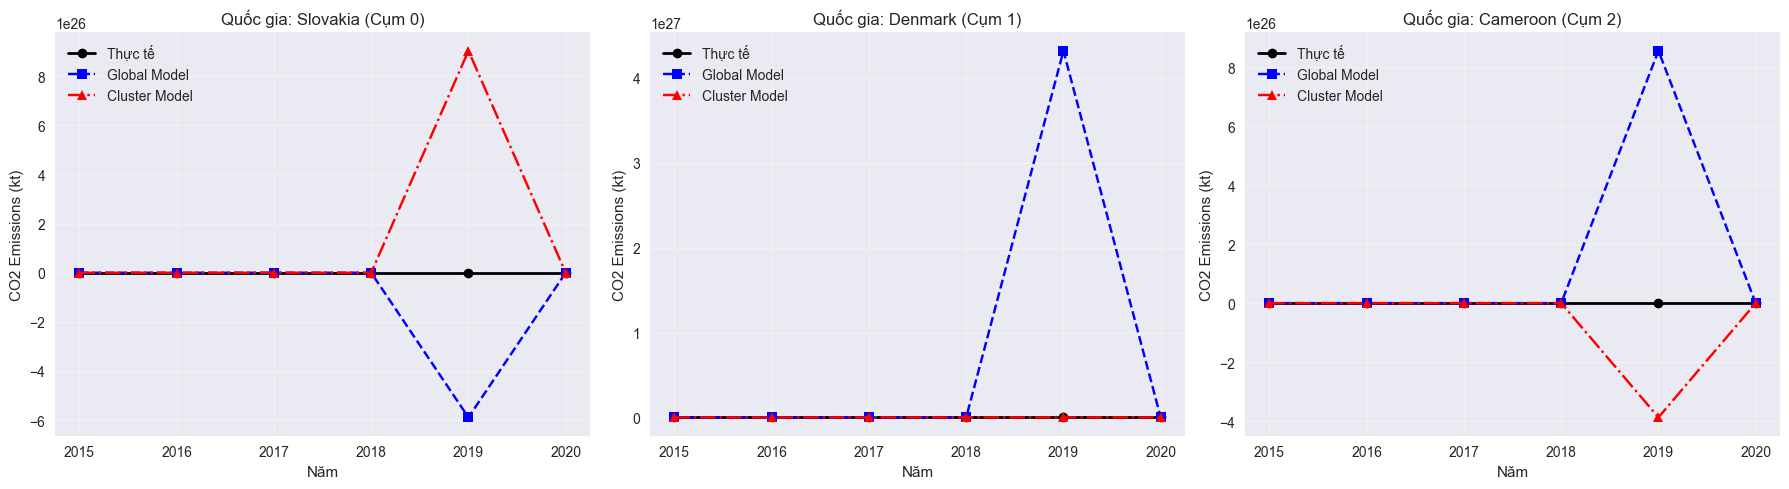

In [6]:
# Chọn 3 quốc gia đại diện cho 3 cụm để vẽ (VD: USA, China, Vietnam... nếu có)
# Lấy ngẫu nhiên 1 nước từ mỗi cụm có trong tập test
sample_entities = []
for c in [0, 1, 2]:
    entities_in_cluster = final_comparison[final_comparison['Cluster'] == c]['Entity'].unique()
    if len(entities_in_cluster) > 0:
        sample_entities.append(np.random.choice(entities_in_cluster))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, entity in enumerate(sample_entities):
    data_e = final_comparison[final_comparison['Entity'] == entity]
    ax = axes[i]
    
    ax.plot(data_e['Year'], data_e[TARGET], 'k-o', label='Thực tế', linewidth=2)
    ax.plot(data_e['Year'], data_e['Pred_Global'], 'b--s', label='Global Model')
    ax.plot(data_e['Year'], data_e['Pred_Cluster'], 'r-.^', label='Cluster Model')
    
    ax.set_title(f"Quốc gia: {entity} (Cụm {data_e['Cluster'].iloc[0]})", fontsize=12)
    ax.set_xlabel("Năm")
    ax.set_ylabel("CO2 Emissions (kt)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()